In [1]:
# DATA TRANSFORM FOR CNY 

# merged - dataframe for futures
# merged2 - dataframe for spot
# cr_extremes - evening trading session daily futures data
# dset, spot_pred - final df's for ML
# Data stored in 'dset.csv' 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import functools as ft

In [3]:
#Read basic data
#Si Futures
si = pd.read_csv('SI/SIC.csv', sep = ';')
#Cr Futures
cr = pd.read_csv('CR/CNYC.csv', sep = ';')
#MIX Futures
mix = pd.read_csv('MIX/MIXC.csv', sep = ';')
#USDRUB_TOM
rub = pd.read_csv('USDRUB_TOM/USDRUBT.csv', sep = ';')
#CNYRUB_TOM
cny = pd.read_csv('CNYRUB_TOM/CNYRUBT.csv', sep = ';')

In [4]:
# Basic column rename
si.columns = si.columns.str.replace('>', '').str.replace('<', '')
cr.columns = cr.columns.str.replace('>', '').str.replace('<', '')
mix.columns = mix.columns.str.replace('>', '').str.replace('<', '')
rub.columns = rub.columns.str.replace('>', '').str.replace('<', '')
cny.columns = cny.columns.str.replace('>', '').str.replace('<', '')

In [5]:
# Date and time to *DT
si['DT'] = si['DATE'].astype(str) + si['TIME'].astype(str)
si['DT'] = pd.to_datetime(si['DT'])
si.reset_index(inplace = True)
si = si.iloc[:,1:]

In [6]:
# Date and time to *DT
mix['DT'] = mix['DATE'].astype(str) + mix['TIME'].astype(str)
mix['DT'] = pd.to_datetime(mix['DT'])
mix.reset_index(inplace = True)
mix = mix.iloc[:,1:]

In [7]:
# Date and time to *DT
cr['DT'] = cr['DATE'].astype(str) + cr['TIME'].astype(str)
cr['DT'] = pd.to_datetime(cr['DT'])
cr.reset_index(inplace = True)
cr = cr.iloc[:,1:]

In [8]:
# Date and time to *DT
rub['DT'] = rub['DATE'].astype(str) + rub['TIME'].astype(str)
rub['DT'] = pd.to_datetime(rub['DT'])
rub.reset_index(inplace = True)
rub = rub.iloc[:,1:]

In [9]:
# Date and time to *DT
cny['DT'] = cny['DATE'].astype(str) + cny['TIME'].astype(str)
cny['DT'] = pd.to_datetime(cny['DT'])
cny.reset_index(inplace = True)
cny = cny.iloc[:,1:]

In [10]:
# Column names change
col_names_rub = ['DATE', 'TIME', 'RO', 'RH', 'RL', 'RC', 'RV', 'DT']
col_names_si = ['DATE', 'TIME', 'SO', 'SH', 'SL', 'SC', 'SV', 'DT']
col_names_mix = ['DATE', 'TIME', 'MO', 'MH', 'ML', 'MC', 'MV', 'DT']
col_names_cny = ['DATE', 'TIME', 'CNO', 'CNH', 'CNL', 'CNC', 'CNV', 'DT']
col_names_cr = ['DATE', 'TIME', 'CO', 'CH', 'CL', 'CC', 'CV', 'DT']
rub.columns = col_names_rub
si.columns = col_names_si
mix.columns = col_names_mix
cny.columns = col_names_cny
cr.columns = col_names_cr

In [11]:
# Remove columns DATE AND TIME
cny = cny.iloc[:,2:]
cr = cr.iloc[:,2:]
rub = rub.iloc[:,2:]
mix = mix.iloc[:,2:]
si = si.iloc[:,2:]

In [12]:
# Add average prices
si['SAVG'] = (si['SO'] + si['SH'] + si['SL'] + si['SC'])/4
cr['CAVG'] = (cr['CO'] + cr['CH'] + cr['CL'] + cr['CC'])/4
cny['CNAVG'] = (cny['CNO'] + cny['CNH'] + cny['CNL'] + cny['CNC'])/4
mix['MAVG'] = (mix['MO'] + mix['MH'] + mix['ML'] + mix['MC'])/4
rub['SAVG'] = (rub['RO'] + rub['RH'] + rub['RL'] + rub['RC'])/4

In [13]:
# Convert Open-Close to percetage difference
si['SP'] = (si['SC'] - si['SO'])/si['SO']
cr['CP'] = (cr['CC'] - cr['CO'])/cr['CO']
mix['MP'] = (mix['MC'] - mix['MO'])/mix['MO']
cny['CNP'] = (cny['CNC'] - cny['CNO'])/cny['CNO']
rub['RP'] = (rub['RC'] - rub['RO'])/rub['RO']

In [14]:
# Merge all FUTURES in single dataframe for storage
# 'merged' df is main for futher data wrangling
merged = pd.merge(pd.merge(si, cr , how = 'left', on = 'DT'), mix, how = 'left', on='DT')
merged = merged.ffill()

In [15]:
# Move DT to first place
fplace = merged.pop('DT')
merged.insert(0, 'DT', fplace)

In [16]:
# Write merged futures data to csv
merged.to_csv('futures_all.csv', sep = ';')

In [17]:
# Divide evening data with all futures
merged_evening_fut =  merged[(merged['DT'].dt.time >= pd.to_datetime('19:00:00').time()) &
                   (merged['DT'].dt.time <= pd.to_datetime('23:59:00').time())]

In [18]:
#Select needed columns in evening data
cr_evening = merged_evening_fut[['DT', 'CH', 'CL', 'CAVG']].reset_index(drop = True)

In [19]:
# Calculate extremes for Cr, store them in separate df 'cr_extremes', add first evening value of AVG price.
cr_extremes = cr_evening.resample('D', on = 'DT').agg({'CH': 'max', 'CL': 'min','CAVG': 'first'})
cr_extremes = cr_extremes.dropna()
cr_extremes.reset_index(inplace=True)

In [20]:
# Calculate max high and min low
cr_extremes['DIFF_H'] = abs(cr_extremes['CH'] - cr_extremes['CAVG'])/cr_extremes['CAVG']*100
cr_extremes['DIFF_L'] = abs(cr_extremes['CAVG'] - cr_extremes['CL'])/cr_extremes['CAVG']*100

In [21]:
# Compare values and calculate the result
def compare_and_assign(diff_h, diff_l):
    if diff_h > diff_l:
        return diff_h
    else:
        return -diff_l

In [22]:
# Create RES with result movement
cr_extremes['RES'] = cr_extremes.apply(lambda row: compare_and_assign(row['DIFF_H'], row['DIFF_L']), axis=1)

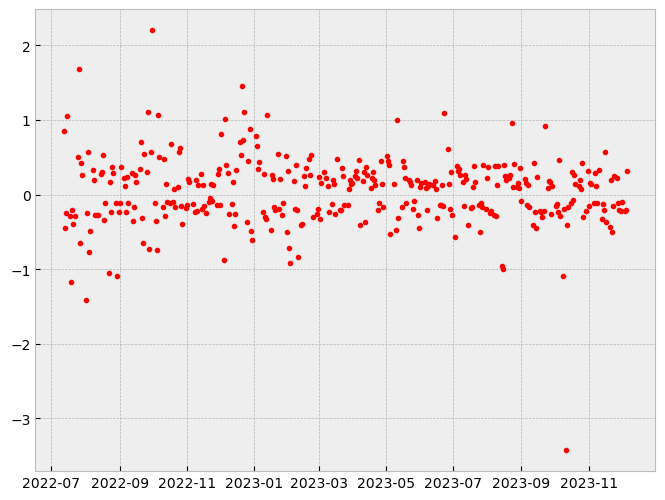

In [23]:
# Check the result - evening movement plot graph
plt.style.use('bmh')
x = cr_extremes['DT']
y = cr_extremes['RES']
plt.figure(figsize=(8,6))
plt.plot(x,y, linewidth=0, **{'color': 'red', 'marker': '.'})
plt.show()

In [24]:
## Merge all SPOT in single dataframe for storage
# 'merged2' df is main for futher data wrangling
merged2 = pd.merge(rub, cny, how = 'left', on = 'DT')
merged2 = merged2.ffill()

In [25]:
# Move DT to first place
fplace2 = merged2.pop('DT')
merged2.insert(0, 'DT', fplace2)

In [26]:
# Count Green and Red candles
def count_candles(rel):
    if rel > 0:
        return 1
    else:
        return 0

In [27]:
#Create columns with number of Green and Red candles
merged2['RELC'] = (merged2['CNC'] - merged2['CNO'])/merged2['CNO']*100
merged2['RELR'] = (merged2['RC'] - merged2['RO'])/merged2['RO']*100
merged2['RESC'] = merged2.apply(lambda row: count_candles(row['RELC']), axis=1)
merged2['RESR'] = merged2.apply(lambda row: count_candles(row['RELR']), axis=1)

In [28]:
#Convert to daily data
merged2_hl = merged2.resample('D', on = 'DT').agg({'CNO': 'first', 'CNC': 'last',
                                                   'RO': 'first', 'RC': 'last',
                                                   'RV': 'sum', 'CNV': 'sum',
                                                   'RESC': 'sum', 'RESR': 'sum', 'RELR': 'count'})
merged2_hl = merged2_hl.dropna()
merged2_hl.reset_index(inplace=True)

In [29]:
# Average volume ratio calculation for USDRUB, using 20 previous days
def rel_volr(merged2_hl):
    merged2_hl['CVol'] = merged2_hl['RV'] / merged2_hl['RV'].rolling(window=20).mean()
    return merged2_hl

merged2_hl = rel_volr(merged2_hl.copy())

In [30]:
# Average volume ratio calculation for CNYRUB, using 20 previous days
def rel_volc(merged2_hl):
    merged2_hl['RVol'] = merged2_hl['CNV'] / merged2_hl['CNV'].rolling(window=20).mean()
    return merged2_hl

merged2_hl = rel_volc(merged2_hl.copy())

In [31]:
# Final independent variables dataframe init
spot_pred = pd.DataFrame()
spot_pred['DT'] = merged2_hl['DT']

In [32]:
spot_pred['RChange'] = (merged2_hl['RC'] - merged2_hl['RO'])/merged2_hl['RO']*100
spot_pred['CChange'] = (merged2_hl['CNC'] - merged2_hl['CNO'])/merged2_hl['CNO']*100
spot_pred['CRatio'] = merged2_hl['RESC']/(merged2_hl['RELR'] - merged2_hl['RESC'])
spot_pred['RRatio'] = merged2_hl['RESR']/(merged2_hl['RELR'] - merged2_hl['RESR'])
spot_pred['RVol'] = merged2_hl['RVol']
spot_pred['CVol'] = merged2_hl['CVol']

In [33]:
# Final working dataframe merge
dset = pd.merge(spot_pred, cr_extremes, on = 'DT')
dset.drop(columns=['DT','CH', 'CL', 'CAVG', 'DIFF_H', 'DIFF_L'], inplace=True)

In [34]:
# Convert evening movement to 1 and 0
def res_sign(res):
    if res > 0:
        return 1
    else:
        return 0

In [35]:
dset['Pred'] = dset.apply(lambda row: res_sign(row['RES']), axis=1)

In [36]:
# Write final df to csv (if needed)
dset.to_csv('dset.csv', sep = ';')